# City Migration
While on [this](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8_%D1%81_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B5_100_%D1%82%D1%8B%D1%81%D1%8F%D1%87_%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%B9) wikipedia site I noticed an opportunity for a data science project. We can see the change in population from 2019 to 2020 in the 173 biggest cities in Russia. Can this be explained through data?

## Libraries needed

In [1]:
from bs4 import BeautifulSoup
import requests 
import pandas as pd
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline
from selenium import webdriver
import time
from selenium.webdriver.common.keys import Keys
import re
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

## Scraping the wikipedia table
The first three rows of the wikipedia table.

In [2]:
wiki_url='https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B3%D0%BE%D1%80%D0%BE%D0%B4%D0%BE%D0%B2_%D0%A0%D0%BE%D1%81%D1%81%D0%B8%D0%B8_%D1%81_%D0%BD%D0%B0%D1%81%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC_%D0%B1%D0%BE%D0%BB%D0%B5%D0%B5_100_%D1%82%D1%8B%D1%81%D1%8F%D1%87_%D0%B6%D0%B8%D1%82%D0%B5%D0%BB%D0%B5%D0%B9'
table_class="wikitable sortable jquery-tablesorter"
response = requests.get(wiki_url)
soup=BeautifulSoup(response.text, 'html.parser')
city_table=soup.find('table', {'class': 'wikitable sortable'})
df=pd.read_html(str(city_table))
df=df[0]
df=pd.DataFrame(df)
df.head(3)

№                      Город Население, тыс. человек        \
  Unnamed: 0_level_1 в1897[16]            Город                    1897  1926   
0                  1         2       Москва[17]                    1039  2080   
1                  2         1  Санкт-Петербург                    1265  1737   
2                  3       NaN      Новосибирск                       8   120   

                                 ...                                     \
   1939  1959  1970  1979  1989  ...   2011   2012   2013   2014   2015   
0  4609  6133  7194  8057  8878  ...  11541  11613  11980  12108  12198   
1  3431  3390  4033  4569  4989  ...   4899   4953   5028   5132   5192   
2   404   885  1161  1309  1420  ...   1475   1499   1524   1548   1567   

                                      
    2016   2017   2018   2019   2020  
0  12330  12381  12506  12615  12678  
1   5226   5282   5352   5384   5398  
2   1584   1603   1613   1618   1626  

[3 rows x 22 columns]

## Elimination of extra columns
Keeping the columns that I'm interested in and renaming them.

In [3]:
city=pd.DataFrame(df.iloc[:,2])
years=df.iloc[:,-2:]
df=pd.concat([city,years], axis=1)
df.columns=['city','19','20']
df.head(3)

,city,19,20
0,Москва[17],12615,12678
1,Санкт-Петербург,5384,5398
2,Новосибирск,1618,1626


## City names
Eight of the city names have many extra characters that will need to be cleaned. 

In [4]:
for city in df.city:
    if '[' in city:
        print(city)

Москва[17]
Балашиха[18]
Севастополь[Крым 1][19]
Симферополь[Крым 1][19]
Подольск[20]
Королёв[21]
Керчь[Крым 1][19]
Евпатория[Крым 1][19]


## Cleaning the city names

In [5]:
for index,row in df.iterrows():
    city=row[0]
    if '[' in city:
        city=city.split('[')[0]
        df.iloc[index,0]=city

## Creating a 'percent change' column
Since cities vary in size and I'm only concerned with the inflow and outflow of citizens I made a columns that shows by what percent a city grew or shrunk in size. 

In [6]:
df['percent_change']=round(100*(df['20']-df['19'])/df['19'],2)
df=df.sort_values('percent_change').reset_index(drop=True)
df

,city,19,20,percent_change
0,Сергиев Посад,102,100,-1.96
1,Калуга,337,332,-1.48
2,Одинцово,138,136,-1.45
3,Березники,141,139,-1.42
4,Мурманск,292,288,-1.37
...,...,...,...,...
168,Ставрополь,437,451,3.20
169,Балашиха,490,507,3.47
170,Долгопрудный,112,116,3.57
171,Каспийск,119,124,4.20


## Percent change distribution
The distribution resembles normality. The distribution is skewed to the right. One city grew by more than 5%. None of the cities sampled had a major loss of population. 

<function matplotlib.pyplot.show(*args, **kw)>

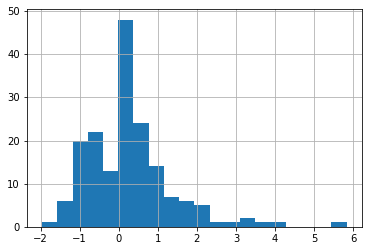

In [7]:
df.percent_change.hist(bins=20)
plt.show

## Creating a labeled column
Each city will now be labeled either 'gain', 'loss', or 'stable' depending if the percent change in population is greater than 0.5%, less than 0%, or in between. 

In [8]:
df['label']=''
for index,row in df.iterrows():
    change=row[3]
    if change > .5:
        df.iloc[index,4]='gain'
    elif change < 0.0:
        df.iloc[index,4]='loss'
    else:
        df.iloc[index,4]='stable'   

## Label distribution 
With such criteria for labeling we are left with tree groups that are roughly the same size. 

In [9]:
df.label.value_counts()

loss      62
stable    60
gain      51
Name: label, dtype: int64

## Coordinates for the cities 
[This](https://gist.github.com/nalgeon/5307af065ff0e3bc97927c832fabe26b) person shared a data set that has the coordinates to many Russian cities. We will add two new columns to represent longitude and latitude. 

In [12]:
cities=pd.read_csv('all_cities.csv')
cities=cities[["Город","Широта","Долгота"]]
cities.columns=['city','long','lat']
cities=cities.set_index('city')
df=df.set_index('city')
df=df.join(cities)
df.head()

,19,20,percent_change,label,long,lat
city,,,,,,
Абакан,186,187,0.54,gain,53.722366,91.443779
Альметьевск,157,158,0.64,gain,54.901366,52.297065
Ангарск,225,225,0.00,stable,52.544810,103.888538
Арзамас,104,104,0.00,stable,55.394754,43.840785
Армавир,190,189,-0.53,loss,45.001034,41.132392


## Missing coordinates
Unfortunately, the data doesn't cover six cities that were chosen for this project.

In [13]:
df.isnull().sum()

19                0
20                0
percent_change    0
label             0
long              6
lat               6
dtype: int64

## Filling in the missing coordinates
I loaded the data into an excel spreadsheet and then manually filled in the missing coordinates. 

In [1]:
df.to_csv('cities.csv',encoding='utf-8-sig')
df=pd.read_csv('cities_fix.csv')

## Mapping Russia's 173 biggest cities
The map also shows if the city is stable (blue circle), growing (green triangle), or shrinking (upside down read triangle) in population. The Moscow region is very cluttered. I was surprised by the amout of big cities in the Caucasus, a much bigger demographic than I realized. I'm also surprised that Sain Petersburg isn't surrounded by other big cities like Moscow is. 

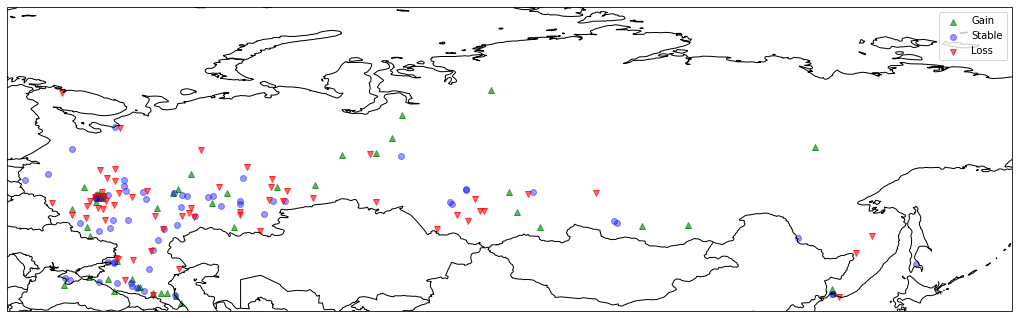

In [15]:
plt.figure(figsize=(18,18))
m = plt.axes(projection=ccrs.RotatedPole())
m.set_extent([26, 155, 41, 80], ccrs.PlateCarree()) 
m.add_feature(cfeature.COASTLINE)
m.add_feature(cfeature.BORDERS) 
for i in df[df['label']=='gain'].itertuples():
    m.scatter(i.lat, i.long, color='green',marker='^',alpha=.6,label='Gain' if i[0] == 0 else "", transform=ccrs.PlateCarree())
for i in df[df['label']=='stable'].itertuples():
    m.scatter(i.lat, i.long, color='blue',marker='o',alpha=.4,label='Stable' if i[0] == 2 else "", transform=ccrs.PlateCarree())
for i in df[df['label']=='loss'].itertuples():
    m.scatter(i.lat, i.long, color='red',marker='v',alpha=.6,label='Loss' if i[0] == 4 else "", transform=ccrs.PlateCarree())
plt.legend()

## Gathering salary data
[Trud.com](https://www.trud.com/elista/salary/1571.html) has the average salary of all major cities in Russia. I scraped this data and added it to the data set. 

In [2]:
df['salary']=0
driver= webdriver.Chrome()
web = webdriver.Chrome()
web.get('https://russia.trud.com/salary/692.html')
for i,r in df.iterrows():
    city=r[0]
    web.get('https://russia.trud.com/salary/692.html')
    search_field=web.find_element_by_xpath('//*[(@id = "field-salary-options-location")]')
    search_field.clear()
    search_field.send_keys(city)
    search_field.send_keys(Keys.RETURN)   
    salary=web.find_element_by_xpath('//*[contains(concat( " ", @class, " " ), concat( " ", "ms__a", " " ))]').text
    df.iloc[i,7]=salary

## Cleaning the new 'salary' column
The ruble sign and commas needs to be remove

In [3]:
df_salary=pd.read_csv('df_salary.csv')
df_salary.salary=df_salary.salary.apply(lambda x: x.replace('₽','').replace(' ',''))
df_salary.salary=df_salary.salary.astype(int)
df_salary.head(3)

,city,19,20,percent_change,label,long,lat,salary
0,Абакан,186,187,0.54,gain,53.722366,91.443779,39275
1,Альметьевск,157,158,0.64,gain,54.901366,52.297065,33592
2,Ангарск,225,225,0.00,stable,52.544810,103.888538,34463


## Creating a 'safty' column
[Domonfond.ru](https://www.domofond.ru/statya/reyting_samyh_bezopasnyh_gorodov_rossii_v_2019_godu/100300) conducted a big survey where responds rated how safe they felt in their city. This survey included all but 19 of my sample cities. 

In [125]:
safty=pd.read_csv('safty.csv',index_col=0,decimal=',')
df_ss=df_salary.set_index('city').join(safty)
df_ss.isnull().sum()

19                 0
20                 0
percent_change     0
label              0
long               0
lat                0
salary             0
safty             19
dtype: int64

## Filling in the missing 'safty' samples
I will fill in the missing values manually on excel. Through google I will get the crime rate of each city. If the city is around the Russian average I will insert the mean (6.7). And if it's above or below the Russian average I'll insert the 75th or 25th percentile.  

In [126]:
df_ss.to_csv('df_ss.csv',encoding='utf-8-sig')
df_ss.safty.describe()

count    157.000000
mean       6.681529
std        0.589091
min        4.500000
25%        6.300000
50%        6.700000
75%        7.000000
max        8.300000
Name: safty, dtype: float64

## Creating a 'vacancy' column
[hh.ru](https://hh.ru/search/vacancy) shows how many job postings there are for each city. I'll web scrape this in and add it to the data set. 

In [8]:
df_ssv=pd.read_csv('df_ss.csv')
df_ssv['vacancy']=0
web = webdriver.Chrome()
for i,r in df_ssv.iloc[81:,:].iterrows():
    city=r[0]
    web.get('https://hh.ru/search/vacancy')
    search_field=web.find_element_by_xpath('//*[contains(concat( " ", @class, " " ), concat( " ", "HH-QueryLength-Observed", " " ))]')
    search_field.send_keys(city)
    search_field.send_keys(Keys.RETURN)   
    time.sleep(2)
    vacancy=web.find_element_by_xpath('/html/body/div[6]/div/div/div[2]/div/div[1]/div/h1').text                          
    df_ssv.iloc[i,-1]=vacancy
df_ssv.to_csv('df_ssv.csv',encoding='utf-8-sig')
     

## Cleaning the 'vacancy' column
I removed the spaces and city names that were also scrapped. 

In [31]:
df_ssv['vacancy']=df_ssv['vacancy'].map(lambda x: ''.join([i for i in x if i.isdigit()]))
df_ssv.vacancy=df_ssv.vacancy.astype(int)
df_ssv['vacancy_rate']=df_ssv['vacancy']/df_ssv['20']

## Feature importance from a Random Forest Classifier
The label column ('stable', 'gain', or 'loss') will be my target variable. My feature variables are the 2019 population, the latitude, the salary, the safty, and the vacancy columns. The feature importance output are all within 7% of each other, which means not one feature is not much better than the others at determining the target variable. 

In [44]:
y=df_ssv.label
X=df_ssv[['19','lat','salary','safty','vacancy_rate']]
feature_names=['Population in 2019','Latitude','Salary','Safty','Vacancy Rate']
model=RandomForestClassifier(n_estimators=500)
model.fit(X,y)
for name, score in zip(feature_names, model.feature_importances_):
    print(name,score)

Population in 2019 0.19781509308575837
Latitude 0.18833861081949138
Salary 0.24223940311799957
Safty 0.19781157285214532
Vacancy Rate 0.1737953201246054


## Scatter plot visualization of the features variables against the percent change variable 
From the scatter plots we can see that none of the features I gathered have a strong correlation with the percent change of population. At this point it is obvious that I do not have the appropriate data to determine if a city will grow or decrease in population. 

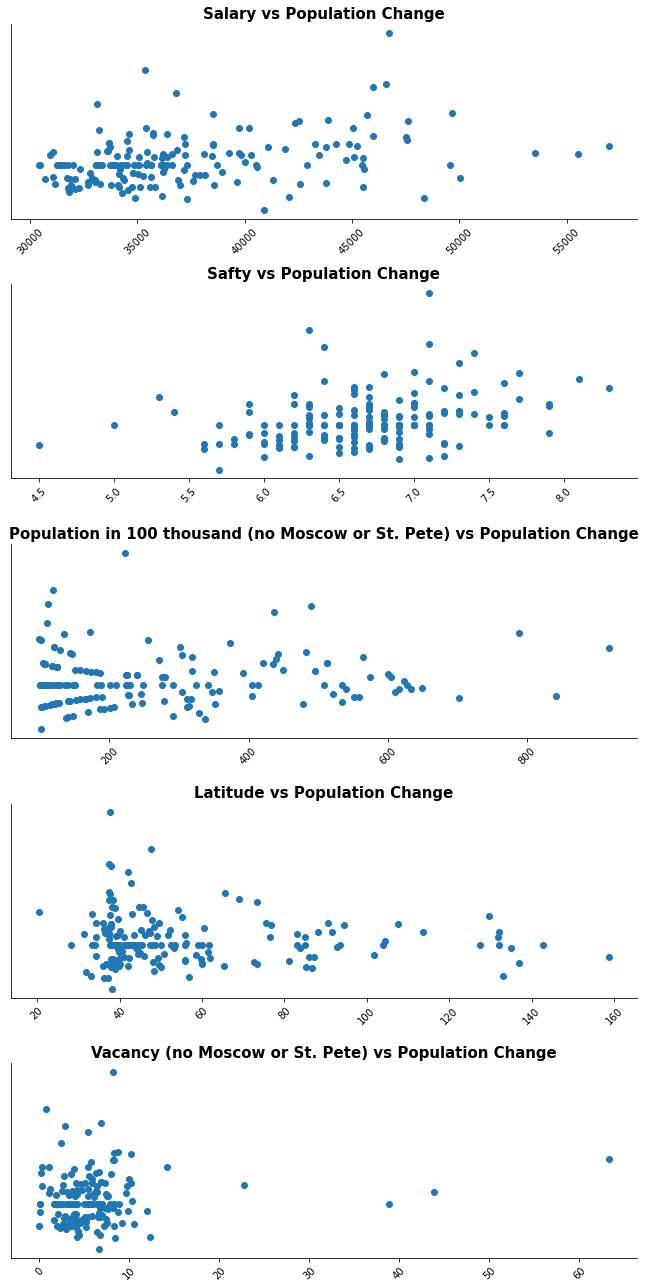

In [7]:
pop=df_ssv[df_ssv['19']<1000]
fig,ax=plt.subplots(5)
fig.set_size_inches(10,18)
ax[0].scatter(df_ssv.salary,df_ssv.percent_change)
ax[0].set_title('Salary vs Population Change', size=15, weight='bold')
ax[1].scatter(df_ssv.safty,df_ssv.percent_change)
ax[1].set_title('Safty vs Population Change', size=15, weight='bold')
ax[2].scatter(pop['19'],pop.percent_change)
ax[2].set_title('Population in 100 thousand (no Moscow or St. Pete) vs Population Change', size=15, weight='bold')
ax[3].scatter(df_ssv.lat,df_ssv.percent_change)
ax[3].set_title('Latitude vs Population Change', size=15, weight='bold')
ax[4].scatter(pop.vacancy_rate,pop.percent_change)
ax[4].set_title('Vacancy (no Moscow or St. Pete) vs Population Change', size=15, weight='bold')
for ax in fig.axes:
    plt.sca(ax)
    plt.yticks([])
    plt.xticks(rotation=45)
    sns.despine(left=False)
plt.tight_layout()

## Next steps
The variables that were gathered were probably not the best. Safty ratings are subjective, hh.ru may be more popular in some cities than others, latitude doesn't precisely describe the climate that might affect one's choice to relocate, and one's salary will have different purchasing powers depending on the city. Finding official statistics for each city proved to be very challenging. I believe that if I had focused on administrative territorial divisions, where there are more official statistics, I would have been able to construct a more meaningful model that could predict population movement. 